In [1]:
import torch
import matplotlib.pyplot as plt

import lightdde as dde

# Define PDE and exact solution

![](equations.png)

In [2]:
Re = 20
nu = 1 / Re
l = 1 / (2 * nu) - (1 / (4 * nu ** 2) + 4 * torch.pi ** 2)**0.5

In [3]:
def pde(x, u):
    u_vel, v_vel, p = u[:, 0:1], u[:, 1:2], u[:, 2:]
    u_vel_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_vel_y = dde.grad.jacobian(u, x, i=0, j=1)
    u_vel_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    u_vel_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)

    v_vel_x = dde.grad.jacobian(u, x, i=1, j=0)
    v_vel_y = dde.grad.jacobian(u, x, i=1, j=1)
    v_vel_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
    v_vel_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)

    p_x = dde.grad.jacobian(u, x, i=2, j=0)
    p_y = dde.grad.jacobian(u, x, i=2, j=1)

    momentum_x = (
        u_vel * u_vel_x + v_vel * u_vel_y + p_x - 1 / Re * (u_vel_xx + u_vel_yy)
    )
    momentum_y = (
        u_vel * v_vel_x + v_vel * v_vel_y + p_y - 1 / Re * (v_vel_xx + v_vel_yy)
    )
    continuity = u_vel_x + v_vel_y

    return [momentum_x, momentum_y, continuity]

In [4]:
def u_func(x):
    return 1 - torch.exp(l * x[:, 0:1]) * torch.cos(2 * torch.pi * x[:, 1:2])

def v_func(x):
    return l / (2 * torch.pi) * torch.exp(l * x[:, 0:1]) * torch.sin(2 * torch.pi * x[:, 1:2])

def p_func(x):
    return 1 / 2 * (1 - torch.exp(2 * l * x[:, 0:1]))

# Define geometry

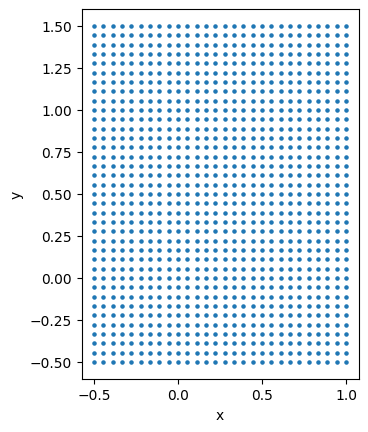

In [5]:
domain = dde.geometry.Hypercube(xmin=[-0.5, -0.5], xmax=[1., 1.5])

# visualisation
sample = domain.uniform_points(1000)
plt.figure()
plt.scatter(sample[:, 0], sample[:, 1], s=5)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Define model

In [6]:
class FNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = torch.nn.Tanh()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 50),
            self.activation,
            torch.nn.Linear(50, 50),
            self.activation,
            torch.nn.Linear(50, 50),
            self.activation,
            torch.nn.Linear(50, 50),
            self.activation,
            torch.nn.Linear(50, 3),
        )

    def forward(self, x):
        x = x.view(-1, 2)
        return self.net(x)

# test run
fnn = FNN()
out = fnn(torch.rand(3, 2))
print(out.shape)
print(out)

# summary
print("Summary:")
from torchsummary import summary
summary(fnn, input_size=(1, 2), device="cpu")

torch.Size([3, 3])
tensor([[-0.1752,  0.0514,  0.1550],
        [-0.1694,  0.0536,  0.1704],
        [-0.1736,  0.0486,  0.1466]], grad_fn=<AddmmBackward0>)
Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]             150
              Tanh-2                   [-1, 50]               0
              Tanh-3                   [-1, 50]               0
            Linear-4                   [-1, 50]           2,550
              Tanh-5                   [-1, 50]               0
              Tanh-6                   [-1, 50]               0
            Linear-7                   [-1, 50]           2,550
              Tanh-8                   [-1, 50]               0
              Tanh-9                   [-1, 50]               0
           Linear-10                   [-1, 50]           2,550
             Tanh-11                   [-1, 50]               0
 

## Define dde.Model

In [7]:
domain = dde.geometry.Hypercube(xmin=[-0.5, -0.5], xmax=[1., 1.5])

In [8]:
boundary_condition_u = dde.bc.DirichletBC(domain,
                                          u_func,
                                          lambda _, on_boundary: on_boundary,
                                          component=0)

boundary_condition_v = dde.bc.DirichletBC(domain,
                                          v_func,
                                          lambda _, on_boundary: on_boundary,
                                          component=1)

def on_boundary_p(x, on_boundary):
    return on_boundary and torch.isclose(x[0], torch.tensor(1.0))

boundary_condition_right_p = dde.bc.DirichletBC(domain,
                                                p_func,
                                                on_boundary_p,
                                                component=2)

In [9]:
data = dde.data.PDEData(
    domain=domain,
    pde=pde,
    bcs=[boundary_condition_u, boundary_condition_v, boundary_condition_right_p],
    exact_solution=[u_func, v_func, p_func],
    num_domain=2601,
    num_bc=400,
    num_test=10000,
)

## Training

In [10]:
model = dde.Model(data, FNN(), save_path="big_model_again", save_every=100)

In [11]:
model.compile()

In [12]:
model.train(10000)

Started training...
epoch: 100, loss_train: 1.2461822032928467, loss_test: [0.8393312096595764, 0.2212458848953247, 0.8673075437545776]
Saved checkpoint at big_model_again
epoch: 200, loss_train: 0.9815580248832703, loss_test: [0.7792844772338867, 0.219030499458313, 0.8208025097846985]
Saved checkpoint at big_model_again
epoch: 300, loss_train: 0.8767590522766113, loss_test: [0.739077627658844, 0.23117168247699738, 0.7767896056175232]
Saved checkpoint at big_model_again
epoch: 400, loss_train: 0.7280534505844116, loss_test: [0.6489372849464417, 0.21744956076145172, 0.7832993865013123]
Saved checkpoint at big_model_again
epoch: 500, loss_train: 0.2965180277824402, loss_test: [0.2662196457386017, 0.15334679186344147, 0.48723310232162476]
Saved checkpoint at big_model_again
epoch: 600, loss_train: 0.1172507181763649, loss_test: [0.1888243407011032, 0.09712523221969604, 0.21618080139160156]
Saved checkpoint at big_model_again
epoch: 700, loss_train: 0.07674086093902588, loss_test: [0.18370

KeyboardInterrupt: 

## Inference

In [13]:
model = dde.Model(data, FNN(), save_path="big_model_again", save_every=100)
model.compile() # automatically loads last checkpoint

Loaded snapshot at epoch 1000


In [14]:
import lightdde as dde

Executed in 0.00 sec.


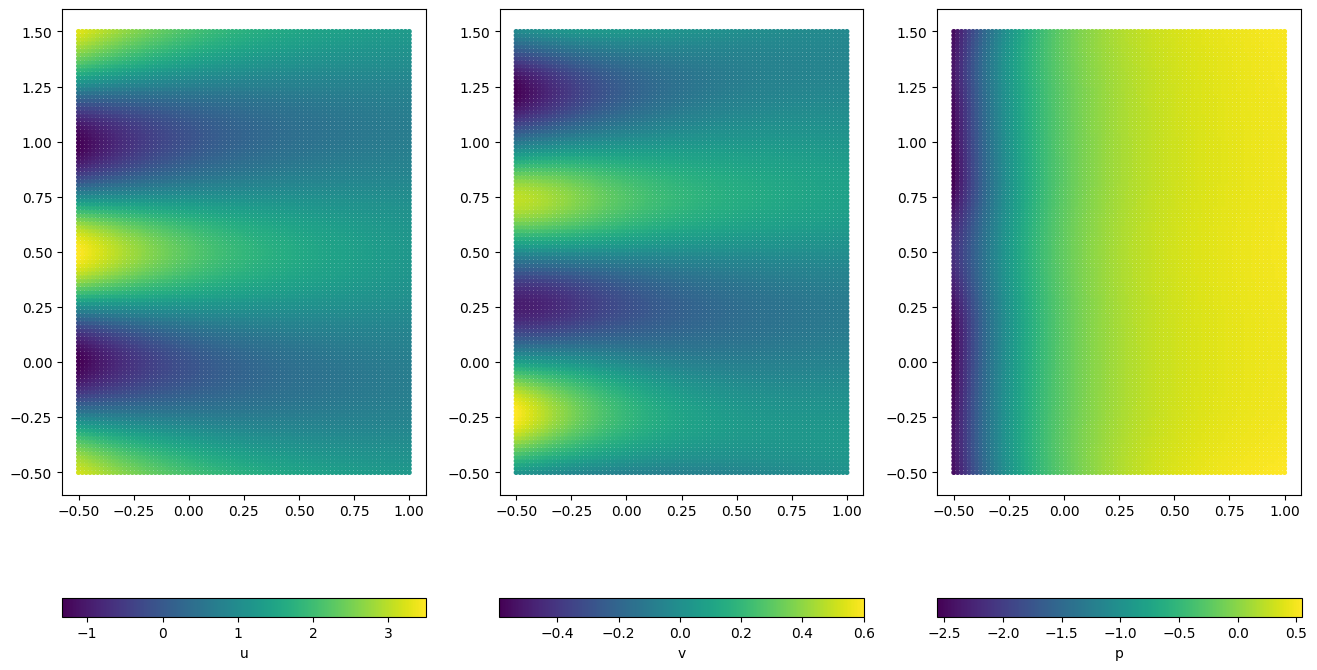

In [15]:
x, pred = dde.plot.scatter_plot(model)